# Region Perturbation POC

Compared to previous notebooks, this notebook should integrate inpainting for the first time as a perturbation technique to the pixel-flipping/region perturbation algorithm.

## LRP

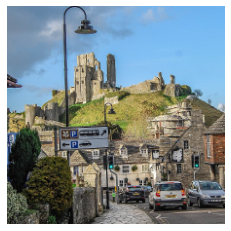

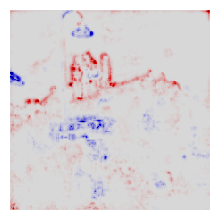

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt

import lrp.plot
import lrp.rules as rules
from lrp import image
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('../../data/castle.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

plt.axis('off')
lrp.plot.plot_imagenet(X)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=2, height=2)

## Region Perturbation

Try Region Perturbation with inpainting enabled.

Finished '_flip' in 1.0527 secs
Finished '_flip' in 1.1061 secs
Finished '_flip' in 1.1127 secs
Finished '_flip' in 1.1438 secs
Finished '_flip' in 1.3735 secs
Finished '_flip' in 1.4259 secs
Finished '_flip' in 1.3663 secs
Finished '_flip' in 1.5345 secs
Finished '_flip' in 1.4760 secs
Finished '_flip' in 1.3474 secs
Finished '_flip' in 1.3085 secs
Finished '__call__' in 15.3171 secs


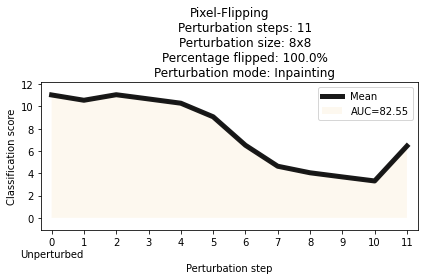

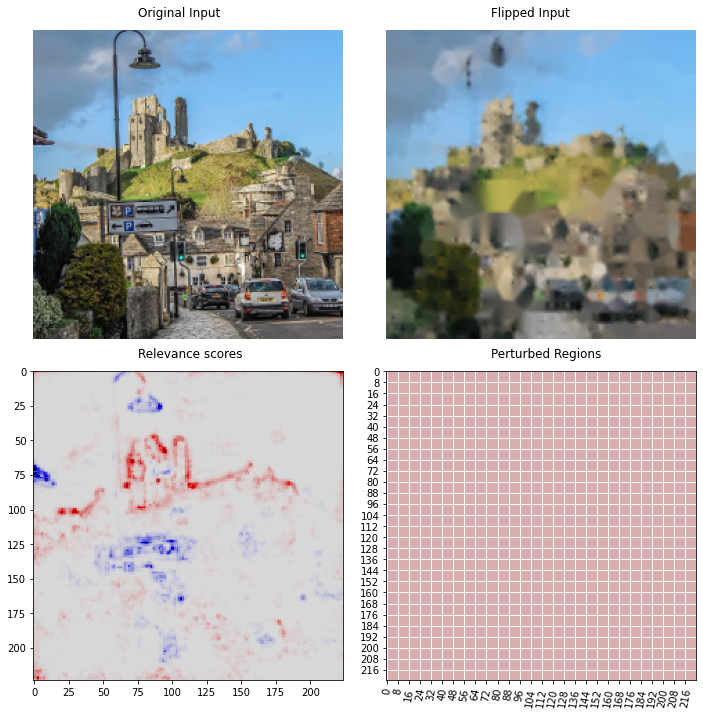

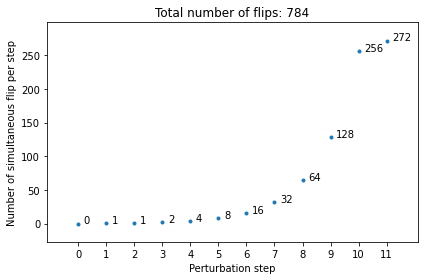

In [2]:
# %%script false --no-raise-error

# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes
from pf.pixel_flipping import PixelFlipping

perturbation_steps: int = 11
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.INPAINTING)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float] = lambda input_nchw: lrp_instance.model(input_nchw)[:,483]

# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()

Finished '_flip' in 1.2450 secs
Finished '_flip' in 1.0888 secs
Finished '_flip' in 1.0913 secs
Finished '_flip' in 1.1381 secs
Finished '_flip' in 1.4215 secs
Finished '_flip' in 1.6217 secs
Finished '_flip' in 1.3110 secs
Finished '_flip' in 1.3557 secs
Finished '_flip' in 1.1359 secs
Finished '_flip' in 1.3435 secs
Finished '_flip' in 1.4161 secs
Finished '__call__' in 15.7906 secs


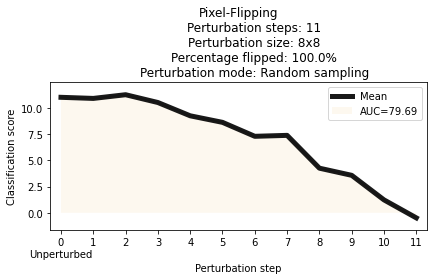

WARNING   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


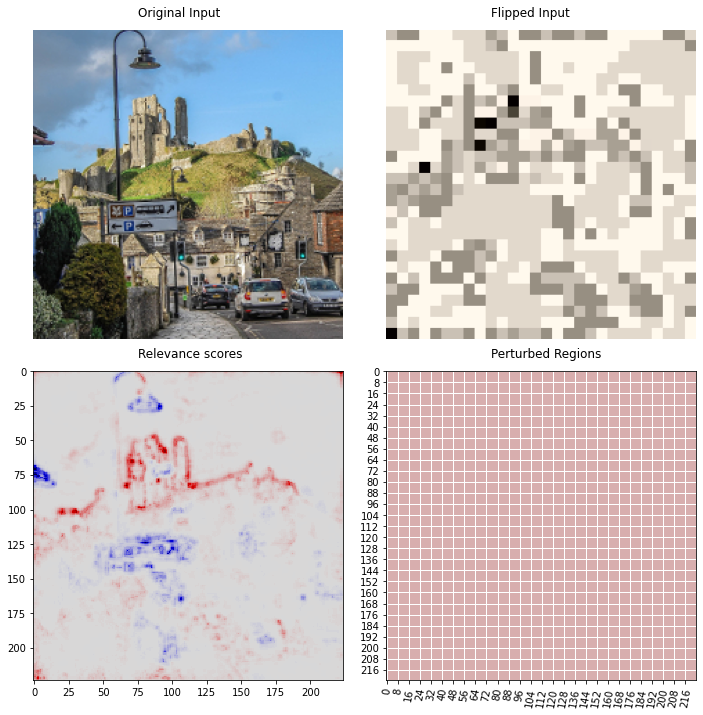

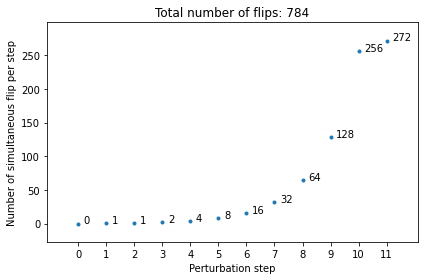

In [3]:
# %%script false --no-raise-error

# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes
from pf.pixel_flipping import PixelFlipping

perturbation_steps: int = 11
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.RANDOM)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float] = lambda input_nchw: lrp_instance.model(input_nchw)[:,483]

# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()